In [1]:
import pandas as pd
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers 
import PIL.Image as Image
%matplotlib inline

In [2]:
Animaldir = "raw-img" #Image local directories
Test_Animal_dir = 'raw2-img'

In [3]:
batch_size = 32
img_height_m4 = 224 #Our second input of images at a larger size
img_width_m4 = 224
img_size_m4 = (224,224)

train_animals_m4 = tf.keras.utils.image_dataset_from_directory(
  Animaldir,
  validation_split=0.2,
  label_mode='int',
  labels = 'inferred',
  class_names = None,
  color_mode = 'rgb',
  subset="training",
  shuffle = True,
  seed = 123,
  image_size=img_size_m4,
  batch_size=batch_size)

val_animals_m4 = tf.keras.utils.image_dataset_from_directory(
  Animaldir,
  validation_split=0.2,
  label_mode='int',
  labels = 'inferred',
  class_names = None,
  color_mode = 'rgb',
  shuffle = True,
  seed = 123,
  subset="validation",
  image_size=img_size_m4,
  batch_size=batch_size)

Found 18686 files belonging to 10 classes.
Using 14949 files for training.
Found 18686 files belonging to 10 classes.
Using 3737 files for validation.


In [4]:
class_names = np.array(train_animals_m4.class_names) #Gets the array of class names
num_classes = len(class_names)

In [5]:
batch_size = 32 #New image size for data augmentation for our pre-trained set
img_height_v2 = 224
img_width_v2 = 224
img_size_v2 = (224,224)

img_shape = img_size_v2 + (3,)

data_augmentation_mobile_v2 = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height_v2,
                                  img_width_v2,
                                   3)),
     layers.RandomRotation(0.2),
     layers.RandomZoom(0.1),    
  ]
)


In [6]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

train_animals_v2 = tf.keras.utils.image_dataset_from_directory( #New import of photos probably redundant
  Animaldir,
  validation_split=0.2,
  label_mode='int',
  labels = 'inferred',
  class_names = None,
  color_mode = 'rgb',
  subset="training",
  shuffle = True,
  seed = 123,
  image_size=img_size_v2,
  batch_size=batch_size)

val_animals_v2 = tf.keras.utils.image_dataset_from_directory(
  Animaldir,
  validation_split=0.2,
  label_mode='int',
  labels = 'inferred',
  class_names = None,
  color_mode = 'rgb',
  shuffle = True,
  seed = 123,
  subset="validation",
  image_size=img_size_v2,
  batch_size=batch_size)

Found 18686 files belonging to 10 classes.
Using 14949 files for training.
Found 18686 files belonging to 10 classes.
Using 3737 files for validation.


In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, #Instantiate pretrained model
                                               include_top=False,
                                               weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train_animals_v2))
feature_batch = pretrained_model(image_batch)
print(feature_batch.shape) #Just general data dimensions

(32, 7, 7, 1280)


In [9]:
pretrained_model.trainable = False #Freezes upper layers
pretrained_model.summary() #All the layers used in the model

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) #Global pooling layer

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape) #32 Batch Size, 10 Classes

(32, 10)


In [12]:
inputs = tf.keras.Input(shape=(224,224,3)) #Input all modules
x = data_augmentation_mobile_v2(inputs)
x = preprocess_input(x)
x = pretrained_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_tf = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001 #Slow learning rate
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model_tf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [15]:
result_v2 = model_tf.fit(train_animals_m4, #This will take 20-30 minutes to run but the results are quite astounding
                    epochs=10,
                    validation_data=val_animals_m4)

Epoch 1/10
468/468 [==============================] - 283s 601ms/step - loss: 1.5347 - accuracy: 0.5109 - val_loss: 0.6610 - val_accuracy: 0.8617
Epoch 2/10
468/468 [==============================] - 277s 592ms/step - loss: 0.7070 - accuracy: 0.7952 - val_loss: 0.3780 - val_accuracy: 0.9200
Epoch 3/10
468/468 [==============================] - 294s 629ms/step - loss: 0.5425 - accuracy: 0.8345 - val_loss: 0.2863 - val_accuracy: 0.9355
Epoch 4/10
468/468 [==============================] - 287s 612ms/step - loss: 0.4687 - accuracy: 0.8552 - val_loss: 0.2421 - val_accuracy: 0.9435
Epoch 5/10
468/468 [==============================] - 284s 606ms/step - loss: 0.4283 - accuracy: 0.8653 - val_loss: 0.2158 - val_accuracy: 0.9454
Epoch 6/10
468/468 [==============================] - 293s 625ms/step - loss: 0.3979 - accuracy: 0.8736 - val_loss: 0.1999 - val_accuracy: 0.9473
Epoch 7/10
468/468 [==============================] - 298s 637ms/step - loss: 0.3831 - accuracy: 0.8779 - val_loss: 0.1900 -

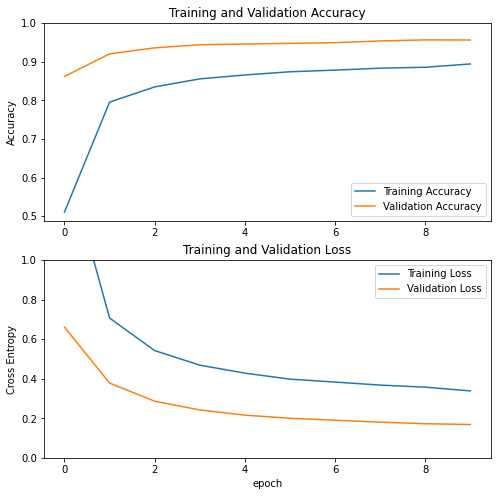

In [17]:
acc = result_v2.history['accuracy'] #Plots performance
val_acc = result_v2.history['val_accuracy']

loss = result_v2.history['loss']
val_loss = result_v2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()